## Compute RAVI

- RA volumes should be measured from the apical four-chamber view.
- The most commonly used method for 2D echocardiographic volume calculations is the biplane method of disks summation (modified Simpson’s rule), which is the recommended 2D echocardiographic method by consensus of this committee
- Note: Two-dimensional echocardiographic image acquisition should aim to maximize RA area

- Measurements and feature names:
    - RAVI - Right atrium end diastolic volume indexed to BSA

- RA size and volume measurements should be reported indexed to BSA. For general reference, 2D echocardiographic 
    - RA volume of 32 mL/m<sup>2</sup> for men and 27 mL/m<sup>2</sup> for women should be used as the upper limits of the corresponding normal range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from utils import util_measurement, stats_and_plots, measurements_dict, BA_plot

In [2]:
def get_dataCat(df,feature1, value):
    """
    transform feature value in categorical
    Input: 
        - dataframe 
        - feature to be categorized. E.g., LAVI_echo_cat, LAV_echo, LAV_model LVMI_echo_cat, LVEF_echo, etc.
        - value to use as normal - Use 0 for RAVI, and RV, 35 for LVEF, normal for others
    """

    df_BA = df.copy()
    if feature1 == 'LVEF_echo':
        df_BA[feature1][df_BA[feature1] > value] = 'Normal' 
    else:
        df_BA[feature1][df_BA[feature1] == value] = 'Normal' 

    df_BA[feature1][df_BA[feature1] != 'Normal'] = 'Abnormal'
    return df_BA[feature1]

## Load Numbers table

In [3]:
### Load Clinical Echo Measurements

df_numbers = pd.read_csv('test_data/RA_volumetrics/RA_volumetrics.csv')
df_numbers.describe()

,BSA,RAVI_echo
count,10.000000,10.000000
mean,1.858390,20.645349
std,0.244305,10.380262
min,1.466470,11.096068
25%,1.707687,14.740351
50%,1.848176,18.887983
75%,1.929922,21.690177
max,2.378569,47.651160


## Load dataframes with RA measurements

In [4]:
df_a4c_allFrames = pd.read_csv('test_data/RA_volumetrics/A4C_measures_R2.csv')
df_a4c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
mean,42.800000,104.325000,94.150000,177.875000,144.125000,15.774689,15.774689,16.757355,142.450000,117.975000,...,115.275000,0.272183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,17.598368,44.846969,29.169311,34.500975,30.378119,5.846603,5.846603,6.125501,35.787084,28.029735,...,30.620077,0.072774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,20.000000,44.000000,36.000000,111.000000,98.000000,1.214600,1.214600,1.336670,85.000000,71.000000,...,54.000000,0.061917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,29.000000,58.500000,72.000000,152.000000,115.750000,13.021851,13.021851,13.406372,110.500000,94.750000,...,91.750000,0.220490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,42.000000,108.000000,95.500000,171.000000,148.500000,15.570068,15.570068,16.629028,142.000000,122.000000,...,115.500000,0.267865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,50.000000,145.500000,115.500000,212.000000,168.750000,18.281555,18.281555,19.027710,177.000000,141.000000,...,142.000000,0.326413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,83.000000,168.000000,147.000000,233.000000,211.000000,26.654053,26.654053,28.906250,193.000000,167.000000,...,175.000000,0.398135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Apply qc rules

In [5]:
# Select the RA labels
df_a4c_RA = df_a4c_allFrames.query('label == "RA"')

# Select the clips which fit the sinusoidal model best
df_a4c_RA = df_a4c_RA.sort_values(by=['Rsquared'], ascending=False).drop_duplicates(subset=['anonid'])

# Select the frames which maximize the RA area
df_a4c_RA = df_a4c_RA.sort_values(by='area', ascending=False).drop_duplicates('ID_clip')
print('Final A4C frames:',df_a4c_RA.shape[0], len(df_a4c_RA.anonid.unique()))

Final A4C frames: 10 10


## Merge Data

In [6]:
# Merge with the clinical data
df_all = df_a4c_RA.merge(df_numbers, on='anonid', how='inner')

## Compute RAVI

In [7]:
df_vol = util_measurement.get_volumetrics(df_all, metric='RAVI')
print(df_vol.shape[0],len(df_vol.ID_clip.unique()))

  0%|          | 0/10 [00:00<?, ?it/s]/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 10/10 [00:00<00:00, 1755.75it/s]

10 10


## Bin RA vol in normal and abnormal

In [8]:
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Cat values for Model Pred
df_vol['RAVI_model_cat'] = df_vol['RAVI_model'].astype(int)
df_vol['RAVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['RAVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.ravi_echo_male_dict)), df_vol['RAVI_model_cat'])
df_vol['RAVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['RAVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.ravi_echo_female_dict)), df_vol['RAVI_model_cat'])

## Cat values for Numbers table 
df_vol['RAVI_echo_cat'] = df_vol['RAVI_echo'].astype(int)
df_vol['RAVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['RAVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.ravi_echo_male_dict)), df_vol['RAVI_echo_cat'])
df_vol['RAVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['RAVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.ravi_echo_female_dict)), df_vol['RAVI_echo_cat'])
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Compute and plot some metrics

Volume - Right Atrium 
(10, 44)


,RAVI_echo,RAVI_model
mean,20.645349,20.703167
std,10.380262,9.595040
min,11.096068,9.804491
max,47.651160,44.707133


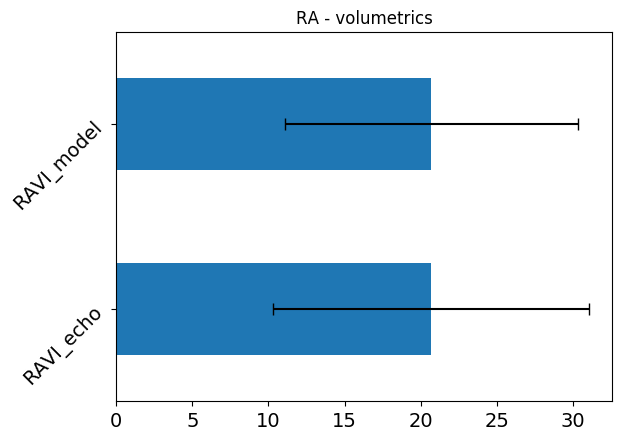

In [9]:
## Mean, std and range of volume.
print('Volume - Right Atrium ')
print(df_vol.shape)
df_vol_stats  = df_vol[['RAVI_echo', 'RAVI_model']].agg(['mean','std','min', 'max'])
display(df_vol_stats)


df_vol_stats.T.plot(kind = "barh", y = ["mean"], legend = False,
            title = 'RA - volumetrics',fontsize=14,  xerr='std', capsize=4,rot=45)
plt.show()

## Regression and Bland-Altman Plots


10


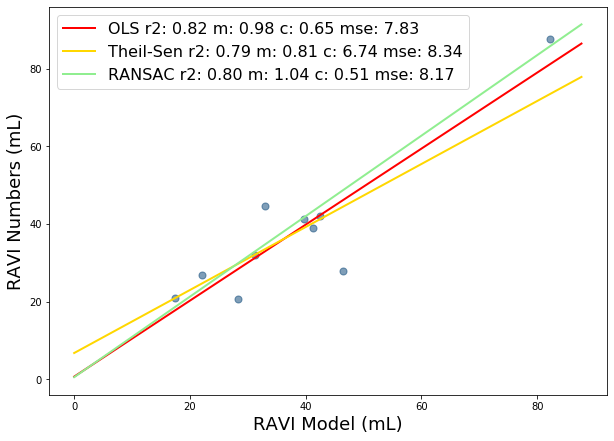

['Normal', 'Abnormal']
['Abnormal' 'Normal']


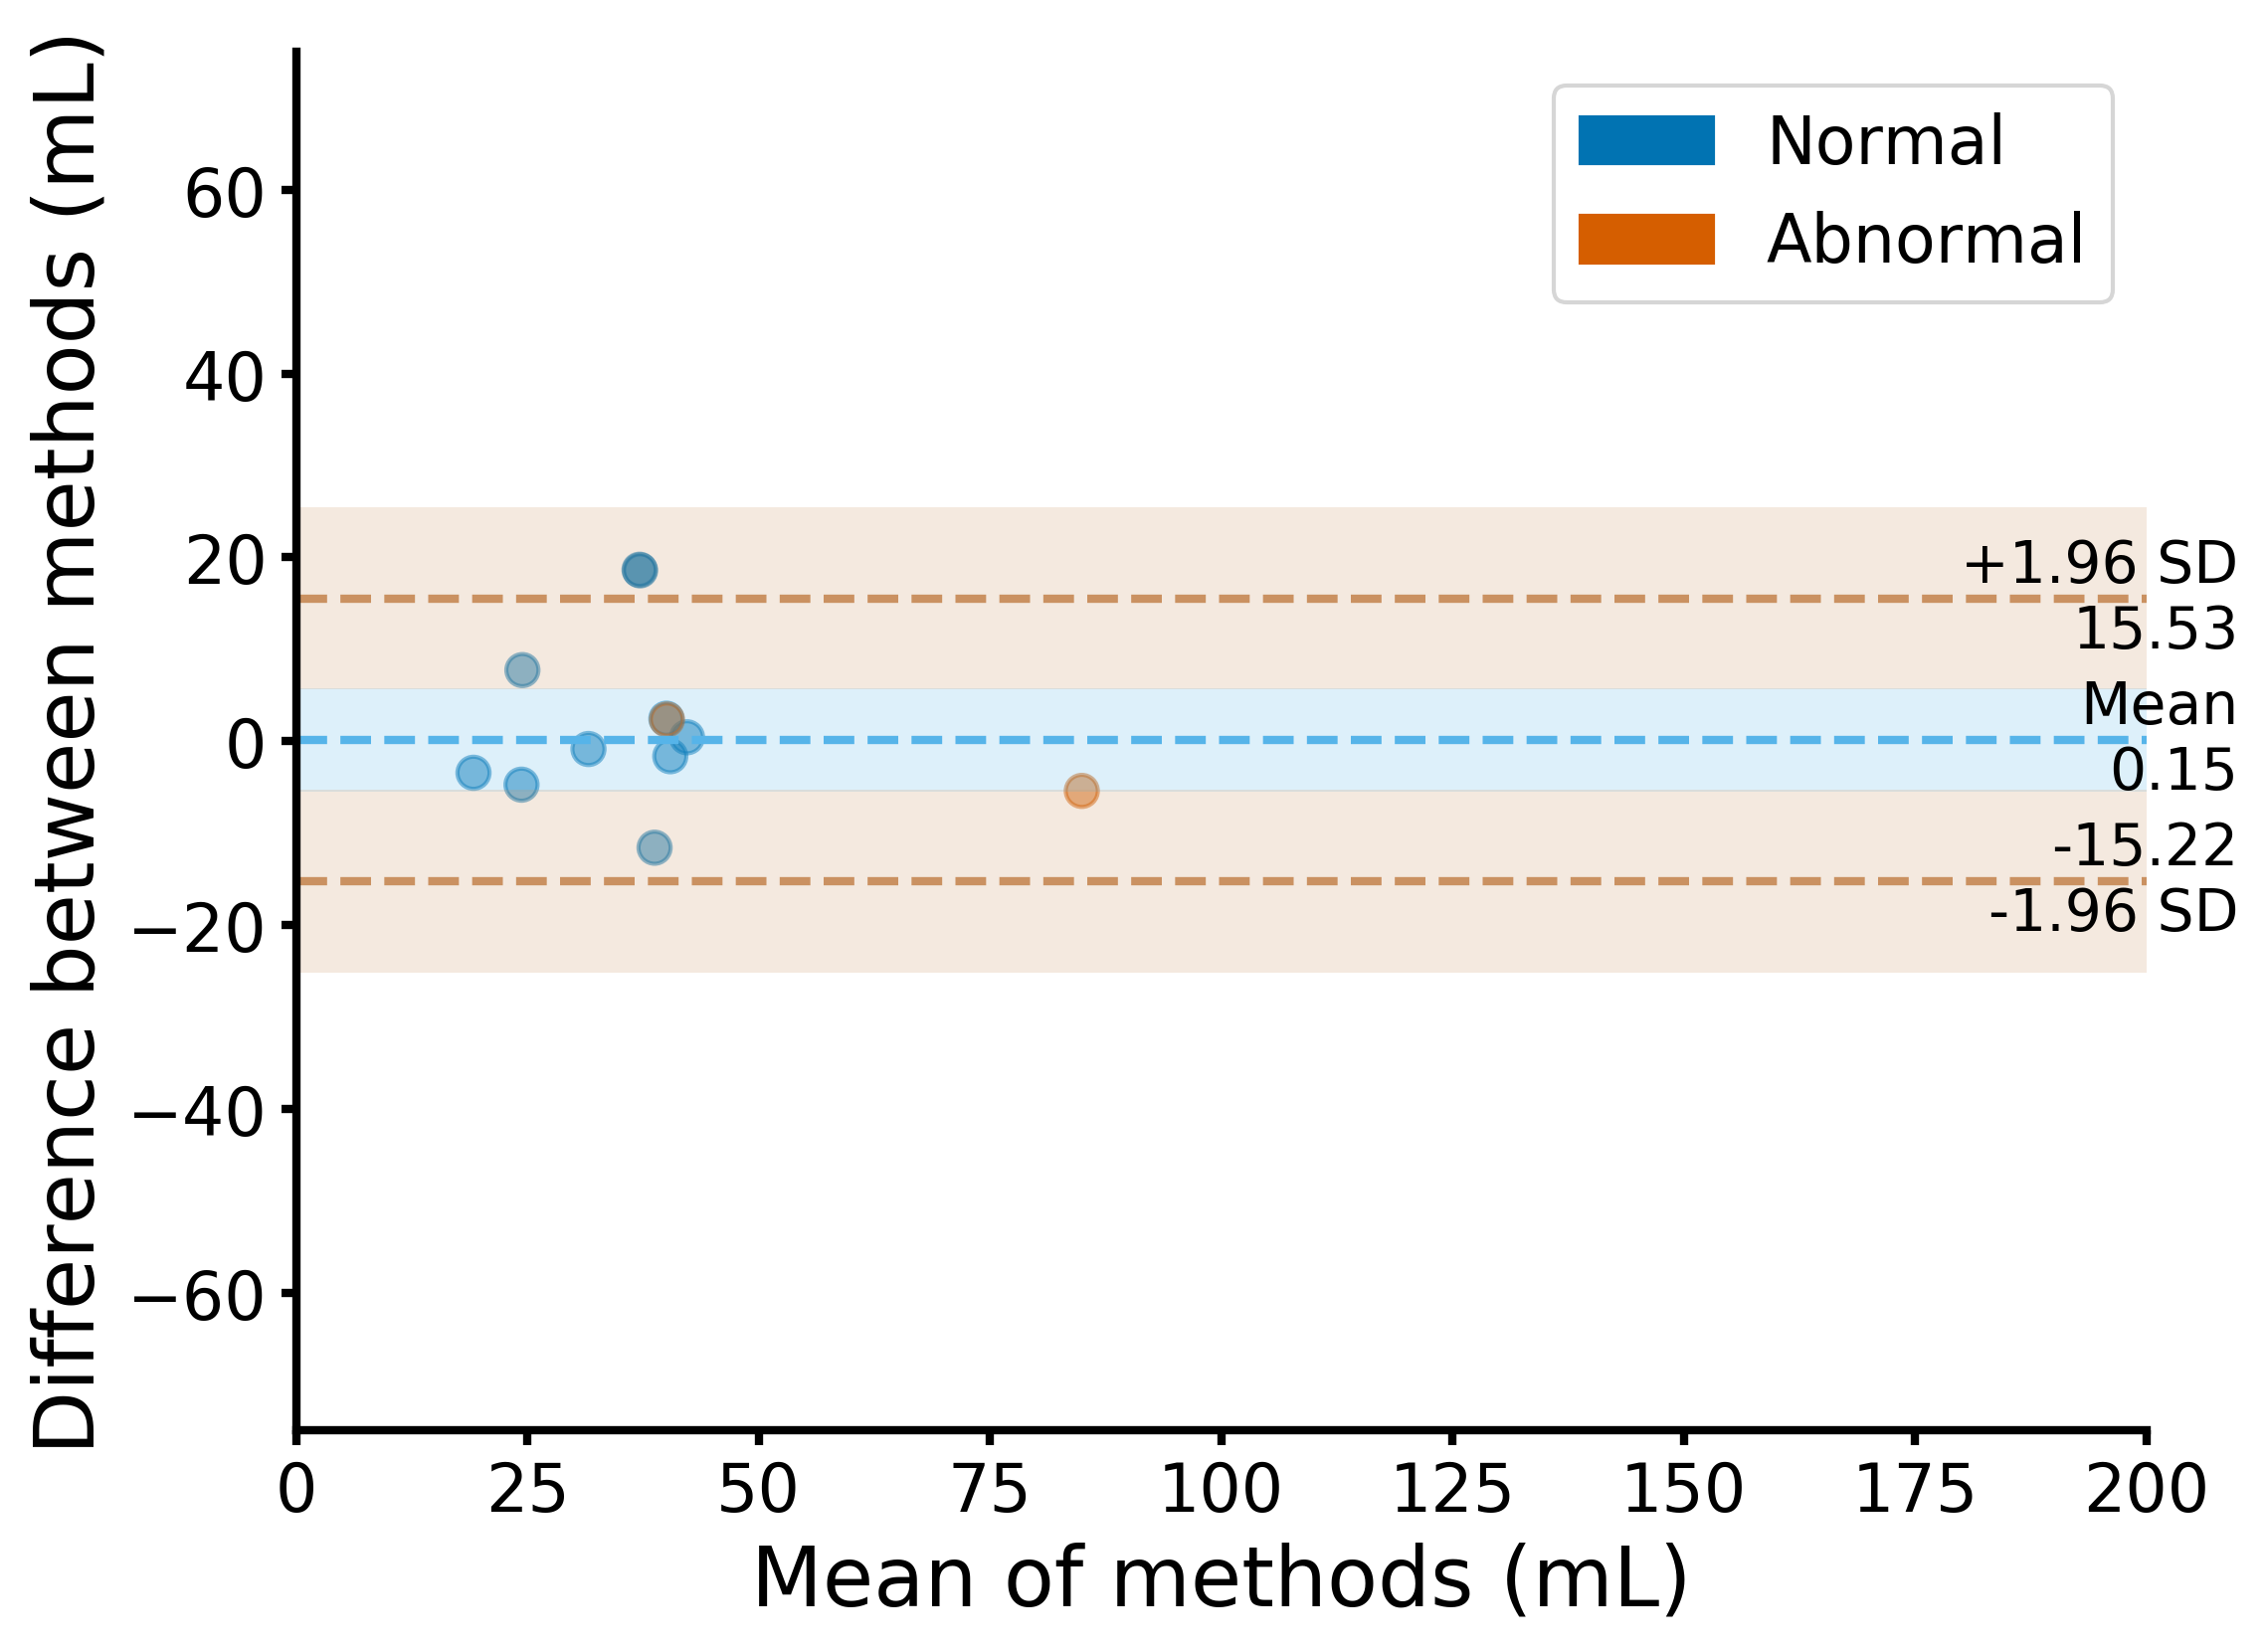

SpearmanrResult(correlation=0.6969696969696969, pvalue=0.02509667588225183)
MWU p-value: MannwhitneyuResult(statistic=47.0, pvalue=0.42505336956926293)


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [10]:
############ RAVI ##################

df_plot = df_vol

ys = df_plot['RAVI_echo'] * df_plot['BSA']
xs = df_plot['RAVI_model'] * df_plot['BSA']
print(len(xs))
stats_and_plots.get_reg_plot(xs,ys,'Numbers-Model','RAVI Model','RAVI Numbers','mL')

dataCat = df_plot.RAVI_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
                    loaColour='#ca9161', pointColour='#0173b2',lim_inf=-75, lim_sup=75, lim_inf_x=0,
                    lim_sup_x=200, cat=True, unity='mL')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

## Plot Confusion Matrix

Confusion Matrix - Numbers vs Unet


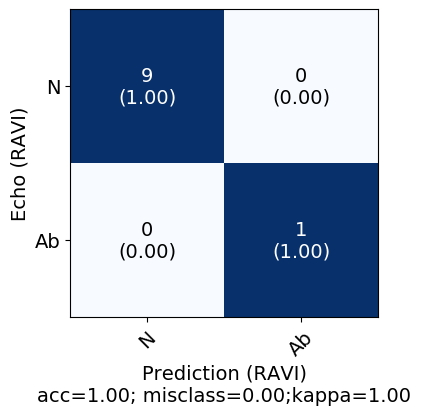

In [11]:
############### RAVI ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['RAVI_echo_cat'] == 'Abnormal'
y_pred = df_vol['RAVI_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (RAVI)')
plt.xlabel('Prediction (RAVI)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()